In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import numpy as np
import pandas as pd

from paths import DATA_PATH

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

import torch

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv')
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


In [3]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    return model_output.pooler_output

In [5]:
title_texts = df.title.fillna('') + df.text.fillna('')
title_texts[:10]

0    Заявки на транзит российского газа через Украи...
1    Юань - хороший инструмент для хеджирования рис...
2    "Сбербанк" увеличил сумму кредита по ипотеке с...
3    Постпреды ЕС в воскресенье не достигли соглаше...
4    Реальные доходы россиян в 2022 году могут упас...
5    США ввели санкции против трех российских телек...
6    Страны G7 договорились сократить импорт нефти ...
7    Минфин США предписал завершить бухгалтерские у...
8    Что будет дальше с рублем? Когда состав участн...
9    Азиатские индексы и нефть снижаются Рубль на м...
dtype: object

In [28]:
embeddings1 = embed_bert_cls(title_texts[:1000].to_list(), model, tokenizer)
embeddings1

tensor([[ 0.2359, -0.2675, -0.4598,  ...,  0.0712,  0.1842, -0.2360],
        [-0.0711, -0.1090, -0.3357,  ..., -0.1869,  0.0874,  0.0272],
        [ 0.1478, -0.1827, -0.5571,  ..., -0.0490,  0.3434, -0.1913],
        ...,
        [-0.0674, -0.0692, -0.0982,  ..., -0.0121, -0.1205, -0.0416],
        [-0.1044, -0.2086, -0.2532,  ...,  0.0576,  0.0977, -0.2665],
        [ 0.1249, -0.3633, -0.4025,  ..., -0.0842, -0.0392, -0.3701]])

In [31]:
embeddings_map = {}

In [32]:
l = list(range(0, len(df), 1000))
l.append(len(df))

for a, b in tqdm(list(zip(l[:-1], l[1:]))):
    if (a, b) in embeddings_map:
        continue
    embeddings_map[(a, b)] = embed_bert_cls(title_texts[a:b].to_list(), model, tokenizer)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:41<00:00,  3.26s/it]


In [34]:
all_embeddings = torch.cat(tuple(embeddings_map.values()))

In [40]:
all_embeddings.shape

torch.Size([30614, 312])

In [59]:
tsne = TSNE(random_state=1, n_components=2)

tsne_embs = tsne.fit_transform(all_embeddings[:1000].numpy())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_53865/3540886830.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


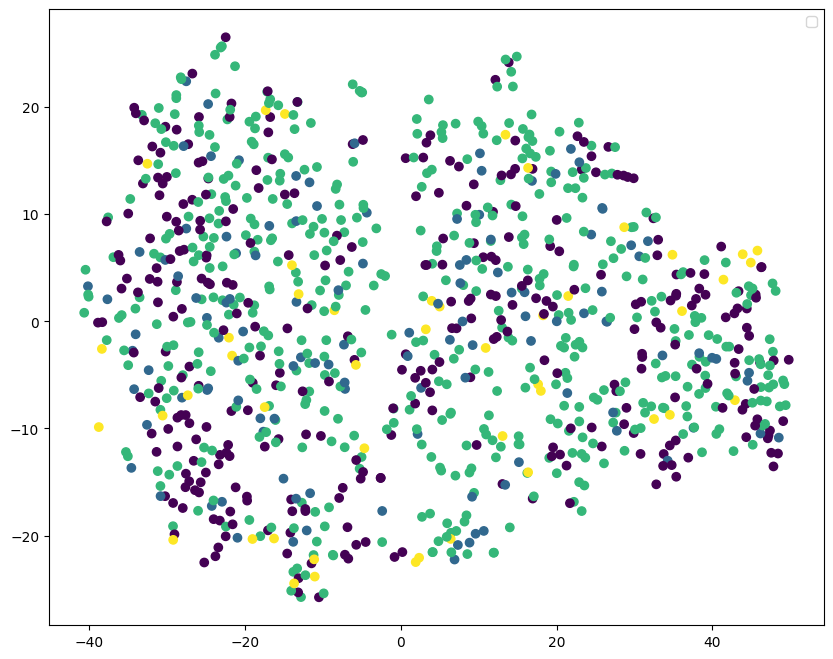

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))
le = LabelEncoder()


c = le.fit_transform(df.label)[:len(tsne_embs)]
ax.scatter(tsne_embs[:, 0], tsne_embs[:, 1], alpha=1, c=c);
ax.legend()
fig.show()

array(['negative', 'neutral', 'positive', nan], dtype=object)